# ModelingToolkit

# 4 Моделирование дискретного поведение с callback

Функции обратного вызова (callback) предоставляют больше возможностей, чем условные выражения. Как мы видели ранее, описание события включает в себя описание *условия*, при котором происходит событие, и описание *воздействия* - изменения, вносимого в модель при возникновении события. 

В MTK выделяют два вида функций обратного вызова - DiscreteCallback и ContinuousCallback.

**DiscreteCallback** используется для моделирования события, которое возникает, когда условие возникновения события принимает значение истины. Условие проверяется только в конце каждого шага интегрирования. В частности с помощью DiscreteCallback удобно моделировать временн*ы*е события (time event).

**ContinuousCallback** используется, когда функция условия задается непрерывной функцией от переменных модели, и ее пересечение с траекторией решения дифференциальных уравнений может происходить между точками начала и конца шага интегрирования. Поэтому моделирование события требует обнаружения события - нахождения момента (корня уравнения), когда условие обращается в ноль. События, управляемые состоянием (state event) - это как раз события, для которых предназначены ContinuousCallback.

In [1]:
using ModelingToolkit, DifferentialEquations, Plots, IfElse

## 4.1 DiscreteCallback 

В разделе 3.1 система описывается дифференциальным уравнением, которое изменяется в момент времени $t=2$. 

\begin{equation*}
 \begin{cases}
 \frac{dx}{dt} = 100 - x,  \text{если }t \le 2
\\
 2\frac{dx}{dt} = 25 - x,  \text{если }t>2
\end{cases}
\end{equation*}
$$x(0)=25$$

Запишем систему на MTK с использованием callback-функции.
Событие `event` представляется парой `<условие> => <вектор воздействий>` и передается конструктору системы `ODESystem` с помощью ключевого слова `discrete_events`.  

In [2]:
@variables t x(t) = 25
@parameters T = 1 a = 100

event = (t == 2) => [a ~ 25; T ~ 2] # событие

der = Differential(t)
eqs = der(x) ~ (a - x)/T
    
@named  model = ODESystem(eqs, t, discrete_events=event)

Model model with 1 equations
States (1):
  x(t) [defaults to 25]
Parameters (2):
  a [defaults to 100]
  T [defaults to 1]

In [3]:
ModelingToolkit.discrete_events(model)

1-element Vector{ModelingToolkit.SymbolicDiscreteCallback}:
 condition: t == 2
affects:
  a ~ 25
  T ~ 2


Как отмечалось выше, условие будет проверяться в конце каждого шага интегрирования. Поскольку в модели условие в виде равенства, событие не произойдет, если только решатель не сделает шаг в точку $t=2$. Как и в случае с IfElse пропишем эту точку в tstops (ниже будет показано, как можно обойтись без этого)

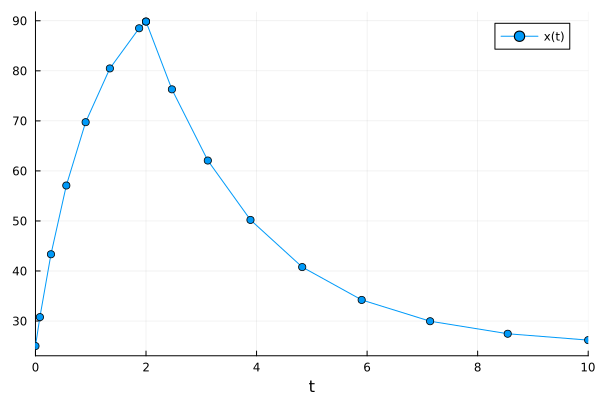

In [4]:
prob = ODEProblem(model, [], [0, 10])
sol = solve(prob, tstops = [2])
plot(sol, denseplot=false, marker=:circle)

Из результатов видно, что условие проверялось на каждом шаге интегрирования. Число обращений к проверке условия (Number of rootfind condition calls) равно числу выполненных шагов (Number of accepted steps)

In [5]:
sol.stats

DiffEqBase.Stats
Number of function 1 evaluations:                  94
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                15
Number of accepted steps:                          15
Number of rejected steps:                          0
Maximum eigenvalue recorded:                       1

Условие может быть любым логическим выражением

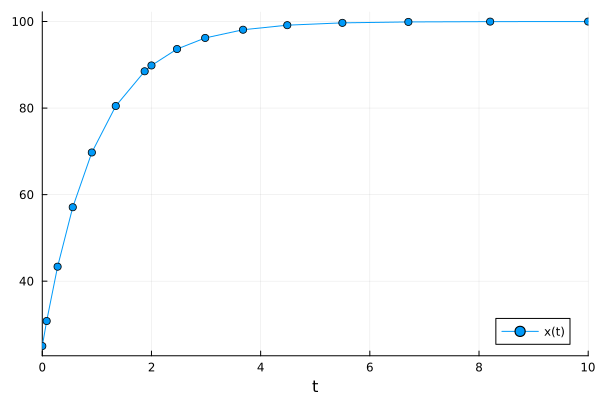

In [6]:
@variables t x(t) = 25
@parameters T = 1 a = 100

event = ((t == 2) & (x <= 70)) => [a ~ 25; T ~ 2]

der = Differential(t)
eqs = der(x) ~ (a - x)/T
    
@named  model = ODESystem(eqs, t, discrete_events=event)

prob = ODEProblem(model, [], [0, 10])
sol = solve(prob, tstops = [2])
plot(sol, denseplot=false, marker=:circle)

Если событий несколько, для передачи в `ODESystem` они объединяются в вектор

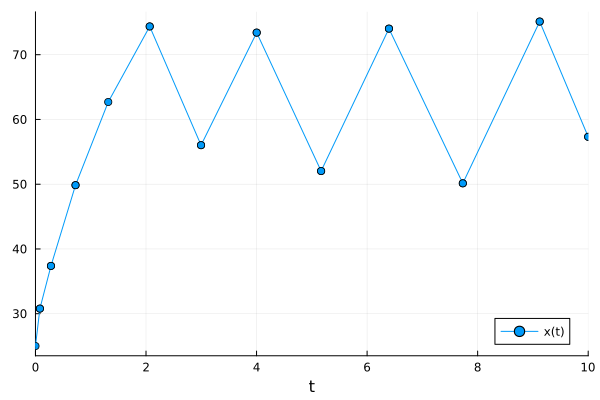

In [7]:
@variables t x(t) = 25
@parameters T = 1 a = 100

event1 = (x >= 70) => [a ~ 25; T ~ 2]
event2 = (x < 60) => [a ~ 100; T ~ 2]

der = Differential(t)
eqs = der(x) ~ (a - x)/T
    
@named  model = ODESystem(eqs, t, discrete_events=[event1, event2])

prob = ODEProblem(model, [], [0, 10])
sol = solve(prob)
plot(sol, denseplot=false, marker=:circle)

В текущей версии МТК **в одном событии нельзя смешивать воздействия на параметры и переменные модели**. Следует разбить на несколько событий 

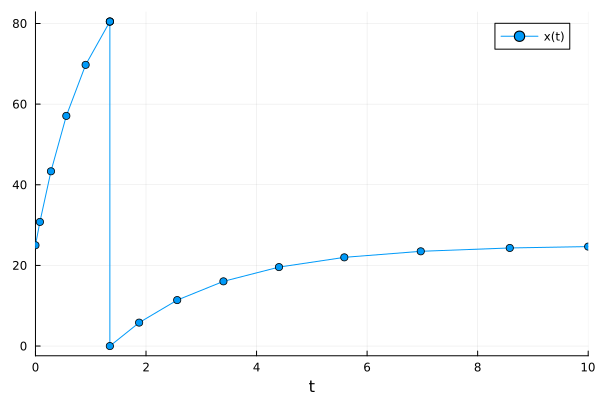

In [8]:
@variables t x(t) = 25
@parameters T = 1 a = 100

#event = (x > 70) => [a ~ 25; T ~ 2; x ~ 0] # так не работает

event1 = (x >= 70) => [a ~ 25; T ~ 2] # изменить параметры
event2 = (x >= 70) => [x ~ 0]         # изменить переменную

der = Differential(t)
eqs = der(x) ~ (a - x)/T
    
@named  model = ODESystem(eqs, t, discrete_events=[event1, event2])

prob = ODEProblem(model, [], [0, 10])
sol = solve(prob)
plot(sol, denseplot=false, marker=:circle)

### 4.1.1 Временн*ы*е события

Для моделирования событий в заданные моменты времени удобнее использовать вариант, не требующий задания `tstops` при вызове решателя. В этом варианте время событий задается в условии в векторе: 

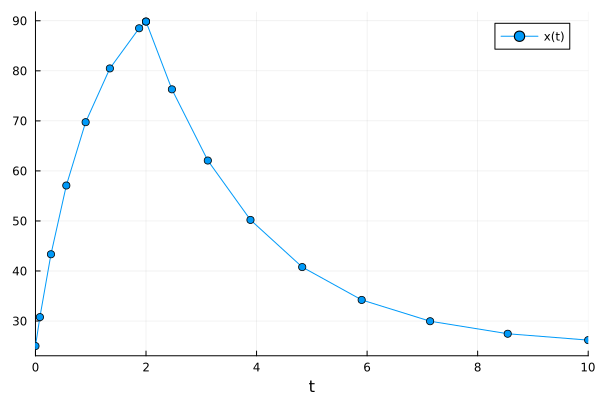

In [9]:
@variables t x(t) = 25
@parameters T = 1 a = 100

event = [2] => [a ~ 25; T ~ 2]  # изменить параметры в t=2

der = Differential(t)
eqs = der(x) ~ (a - x)/T
    
@named  model = ODESystem(eqs, t, discrete_events=event)

prob = ODEProblem(model, [], [0, 10])
sol = solve(prob)
plot(sol, denseplot=false, marker=:circle)

Таким образом можно задавать множество событий, возникающих в разные моменты времени, но реализующим одно и тоже воздействие

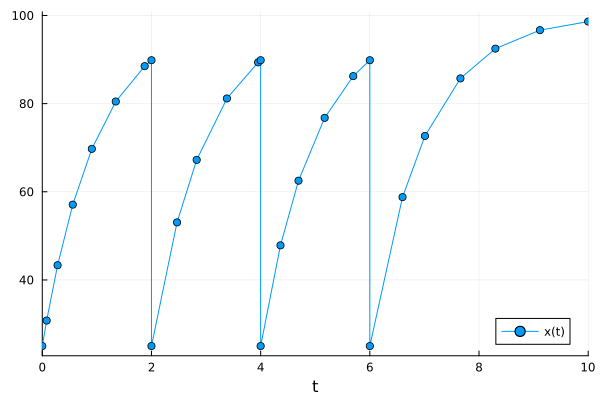

In [10]:
@variables t x(t) = 25
@parameters T = 1 a = 100

event = [2, 4, 6] => [x ~ 25] # изменить переменную в t=2,4 и 6

der = Differential(t)
eqs = der(x) ~ (a - x)/T
    
@named  model = ODESystem(eqs, t, discrete_events=event)

prob = ODEProblem(model, [], [0, 10])
sol = solve(prob)
plot(sol, denseplot=false, marker=:circle)

### 4.1.2 Периодические временн*ы*е события

Если в условии вместо вектора времен задать скаляр `τ`, то событие будет происходит с периодом `τ`:

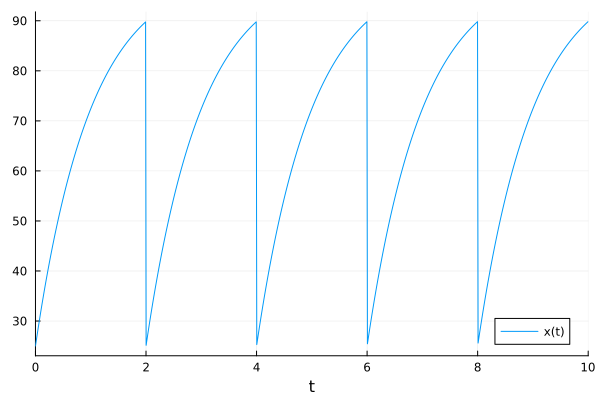

In [11]:
@variables t x(t) = 25 
@parameters T = 1 a = 100

event = 2 => [x ~ 25] # период τ = 2

der = Differential(t)
eqs = der(x) ~ (a - x)/T
    
@named  model = ODESystem(eqs, t, discrete_events=event)

prob = ODEProblem(model, [], [0, 10])
sol = solve(prob)
plot(sol)

## 4.2 ContinuousCallback

Событие записывается в виде `<вектор условий> => <вектор воздействий>`.

Условие - это уравнение, корень которого определяет момент запуска события

В следующем примере, когда `x` достигает 70, происходит сброс значения `x` до 25

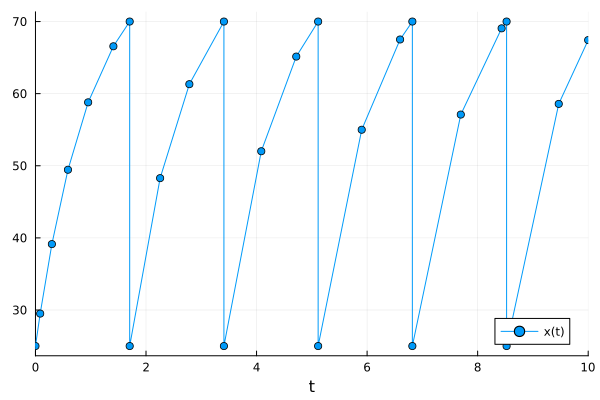

In [12]:
@variables t x(t) = 25

@parameters T = 1 a = 80

event = [x ~ 70] => [x ~ 25]

der = Differential(t)
eqs = der(x) ~ (a - x)/T

@named  model = ODESystem(eqs, t, continuous_events=event)

prob = ODEProblem(model, [], [0, 10])
sol = solve(prob)
plot(sol, denseplot=false, marker=:circle)

In [13]:
ModelingToolkit.continuous_events(model)

1-element Vector{ModelingToolkit.SymbolicContinuousCallback}:
 ModelingToolkit.SymbolicContinuousCallback(Equation[x(t) ~ 70], Equation[x(t) ~ 25])

Просмотр результатов показывает, что условие число обращений к проверке условия события больше, чем число шагов, что связано с поиском обнаружения события

In [14]:
sol.stats

DiffEqBase.Stats
Number of function 1 evaluations:                  128
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                305
Number of accepted steps:                          20
Number of rejected steps:                          0
Maximum eigenvalue recorded:                       1

## 4.3 Больше возможностей

Функции обратного вызова имеют более широкое применение, чем просто моделирование изменений в траектории системы. Больше информации см. [здесь](https://docs.sciml.ai/DiffEqDocs/stable/features/callback_functions/) 

Реализуем следующую реакцию на событие:
* вывод на экран момента возникновения события
* вывод на экран значения переменной в момент события
* сохранение значения переменной в массив data для последующего анализа
* изменение значения переменной
* останов расчета после 5 события

Для этого создадим функцию `save_event!(integ, u, p, data)`, где `integ` - интегратор, `u` - массив переменных, `p` - массив параметров, `data` - переменная произвольного типа.

В событийной паре определим воздействие как кортеж `(affect!, [x], [], data)` из имени функции, массива передаваемых переменных, массива передаваемых параметров и переменной произвольного типа.

In [15]:
function save_event!(integ, u, p, data)
    println("time is $(integ.t)")
    println("x is $(integ.u[u.x])")
    push!(data, integ.u[u.x])
    integ.u[u.x] = 25
    if length(data) >= 5
        terminate!(integ)
    end
end

data = []

@variables t x(t) = 25
@parameters T = 1 a = 80

event = [x ~ 70] => (save_event!, [x], [], data)

der = Differential(t)
eqs = der(x) ~ (a - x) / T

@named  model = ODESystem(eqs, t, continuous_events=event)

prob = ODEProblem(model, [], [0, 50])
sol = solve(prob);

time is 1.7047310156831363
x is 69.99999999999999
time is 3.4095163081731585
x is 69.99999999999996
time is 5.114128169189633
x is 69.99999999999999
time is 6.818795832768088
x is 69.99999999999999
time is 8.523754266589407
x is 69.99999999999999


In [16]:
data

5-element Vector{Any}:
 69.99999999999999
 69.99999999999996
 69.99999999999999
 69.99999999999999
 69.99999999999999

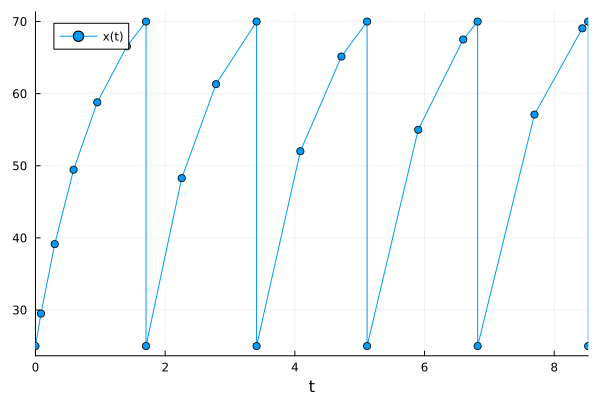

In [17]:
plot(sol, denseplot=false, marker=:circle)

## 4.4 Примеры
### 4.4.1 Вывод из равновесия маятника Капицы

Приложим к маятнику (раздел 3.5.3) импульс силы в моменты $t=1$ и $t=10$

In [18]:
@variables t
@variables θ(t) = 0
@variables dθ(t) = 0
@variables x(t)
@variables y(t)
@variables y₀(t)

@parameters L = 1
@parameters A = 0.05
@parameters ω = 200
@parameters γ = 0.3 # коэффициент затухания
@constants g = 9.80665

D = Differential(t)

force1 = [1] => [dθ ~ dθ + 6] # запись в виде D(θ) не понимает
force2 = [10] => [dθ ~ dθ + 7] 

eqs = [
    D(θ) ~ dθ
    D(dθ) + 2γ*dθ - g / L * sin(θ) ~ - A / L * ω^2 * sin(ω*t) * sin(θ)
    x ~ - L * sin(θ)
    y ~ y₀ + L * cos(θ)
    y₀ ~ A * sin(ω*t)
    ]

@named PendulumKapitza = ODESystem(eqs, t, discrete_events=[force1, force2])

sys = structural_simplify(PendulumKapitza)

Model PendulumKapitza with 2 equations
States (2):
  θ(t) [defaults to 0]
  dθ(t) [defaults to 0]
Parameters (4):
  L [defaults to 1]
  γ [defaults to 0.3]
  A [defaults to 0.05]
  ω [defaults to 200]
Incidence matrix:2×5 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ⋅  ×  ×  ⋅  ⋅
 ×  ×  ⋅  ⋅  ×

  5.331281 seconds (7.51 M allocations: 469.369 MiB, 1.79% gc time, 95.78% compilation time)


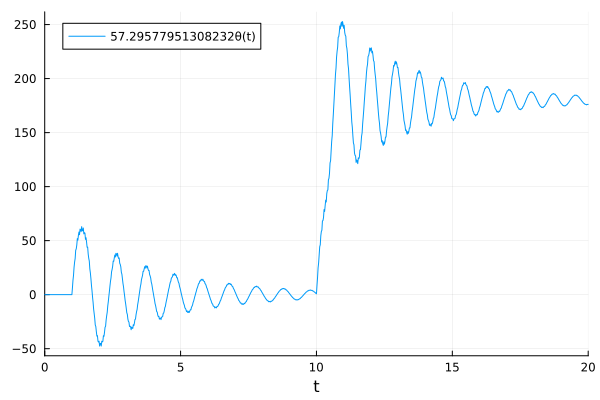

In [19]:
prob = ODEProblem(sys, D.(states(sys)) .=> 0.0, [0.0, 20.0])
@time sol = solve(prob, Rodas4(), reltol=1e-8, abstol=1e-8, saveat=0.02)
plot(sol, idxs=θ*180/pi)

[ Info: Saved animation to /home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif


Plots.AnimatedGif("/home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif")
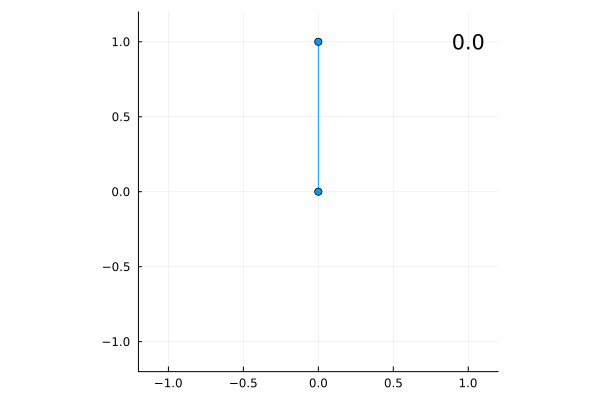

In [20]:
@gif for i in 1:1000
    plot([0, sol[x][i]], [sol[y₀][i], sol[y][i]], 
        label="", xlims=(-1.2, 1.2), ylims=(-1.2, 1.2), marker=:circle, aspect_ratio=1)
    annotate!(1, 1, "$(floor(sol[t][i], digits=1))")
    if sol[t][i] in (1, 10) 
        annotate!(0.2, 1, "<=")
    end
end every 2

### 4.4.2 Мяч,  скачущий по ступеням
Мяч, движущийся по горизонтали со скоростью 1 м/c, падает с высоты 6 м на ступени. Каждый следующий удар приходится на ступень ниже.

Уравнения движения мяча:

\begin{equation*}
 \begin{cases}
 \frac{dy^2}{d^2t} = -g
\\
 \frac{dx^2}{d^2t}=0
\\
\end{cases}
\end{equation*}

В модели $h$ - высота текущей ступени. Поскольку число переменных становится больше числа уравнений, для получения сбалансированной модели добавим уравнение $\frac{dh}{dt}=0$

In [21]:
@variables t 
@variables x(t) = 0
@variables y(t) = 6
@variables vx(t) = 1
@variables vy(t) = 0
@variables h(t) = 5

D = Differential(t)

bounce = [y - h ~ 0] => [vy ~ -0.9vy; vx ~ 0.9vx; h ~ max(0, h-1)]

eqs = [
    D(x) ~ vx
    D(y) ~ vy
    D(vy) ~ -9.8
    D(vx) ~ 0
    D(h) ~ 0
]
@named Ball = ODESystem(eqs, t; continuous_events = bounce)

Model Ball with 5 equations
States (5):
  x(t) [defaults to 0]
  y(t) [defaults to 6]
  vy(t) [defaults to 0]
  vx(t) [defaults to 1]
  h(t) [defaults to 5]
Parameters (0):

  3.712789 seconds (4.88 M allocations: 256.427 MiB, 2.44% gc time, 99.98% compilation time)


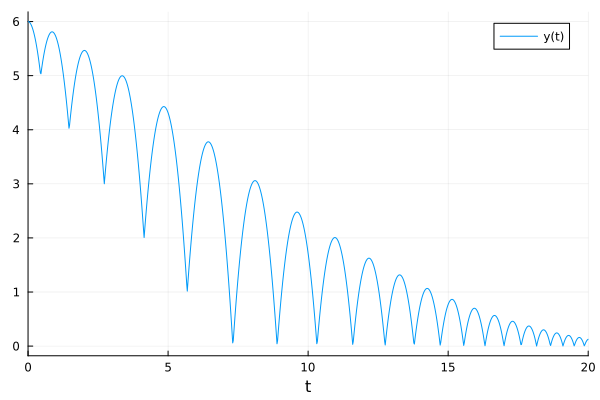

In [22]:
prob = ODEProblem(Ball, [], [0.0, 20.0])
@time sol = solve(prob)
plot(sol, idxs=y)

[ Info: Saved animation to /home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif


Plots.AnimatedGif("/home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif")
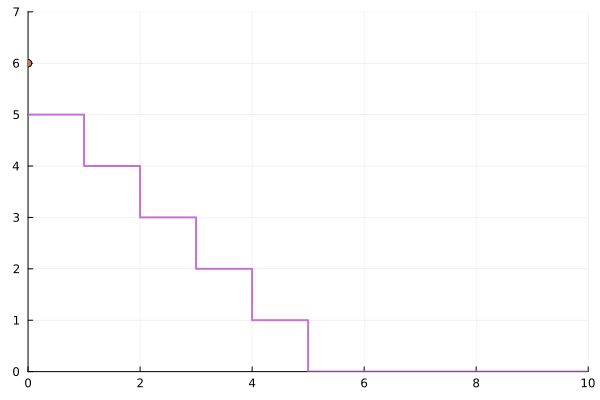

In [23]:
@gif for tm in 0:0.1:20
    plot([sol([tm])[x], sol([tm])[x]], [sol([tm])[y], sol([tm])[y]], 
        label="", xlims=(0, 10), ylims=(0, 7), marker=:circle)
    plot!(sol(0:0.02:tm)[x], sol(0:0.02:tm)[y], 
        label="", la=0.3)
    plot!([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 10], [5, 5, 4, 4, 3, 3, 2, 2, 1, 1, 0, 0], 
        label="", lw=2)
end every 1

### 4.4.3 Электрическая цепь

В электрической цепи смоделируем событие - включение резистора параллельно r1 (т.е. уменьшение сопротивления r1 в 2 раза) в момент $t=0.4$

![Image](http://ets.ifmo.ru/osipov/os1/3_2.files/image031.jpg)

\begin{equation*}
 \begin{cases}
   -i_1 + i_2 +i_L = 0 
   \\
   r_1 i_1 + r_2 i_2 =E
   \\
   u_L=L\frac{di_L}{dt}=r_2 i_2
 \end{cases}
\end{equation*}

где 

\begin{equation*}
r1= \begin{cases}
   0.2, \text{если } t\le 0.4 
   \\
   0.1, \text{если } t>0.4 
 \end{cases}
\end{equation*}

In [24]:
@variables t 
@variables i₁(t) = 50
@variables i₂(t) = 0
@variables iₗ(t) = 50

@parameters E = 10.0 
@parameters r₁ = 0.2 
@parameters r₂ = 0.2 
@parameters L = 0.01 

discrete_events = [[0.4] => [r₁ ~ r₁/2]]
    
der = Differential(t)
eqs = [
    0 ~ i₂ - i₁ + iₗ
    E ~ r₁ * i₁ + r₂ * i₂
    der(iₗ) ~ r₂ * i₂ / L
    ]

@named Circuit = ODESystem(eqs, t, discrete_events = discrete_events)

sys = structural_simplify(Circuit)

Model Circuit with 2 equations
States (2):
  iₗ(t) [defaults to 50]
  i₁(t) [defaults to 50]
Parameters (4):
  E [defaults to 10.0]
  r₁ [defaults to 0.2]
  r₂ [defaults to 0.2]
  L [defaults to 0.01]
Incidence matrix:2×3 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ×  ×  ×
 ×  ⋅  ×

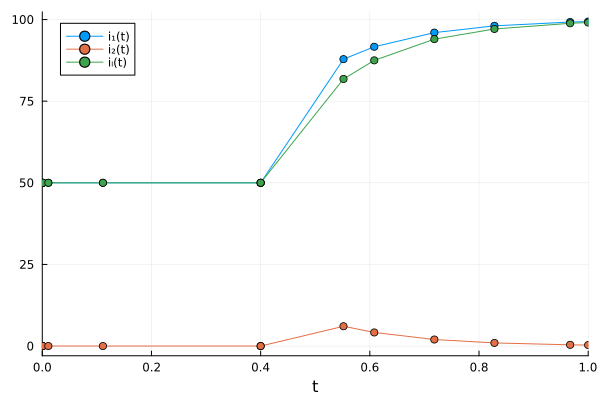

In [25]:
prob = ODEProblem(sys, [], [0, 1])
sol = solve(prob)
plot(sol, idxs=[i₁, i₂, iₗ], denseplot=false, marker=:circle)

После события решатель сразу делает большой шаг, и скачок токов "смазывается". Поэтому из графика может сложиться впечатление, что расчет неверный. Увеличение точности или уменьшение шага исправит картину, но за счет увеличения расчетного времени. Вместо этого добавим принудительно с помощью `tstops` точку "сразу после события", отличающуюся от `t=0.4` на небольшую величину, и убедимся, что траектории совпадают. Просто в момент переключения MTK сохраняет значение переменной только "сразу до события".

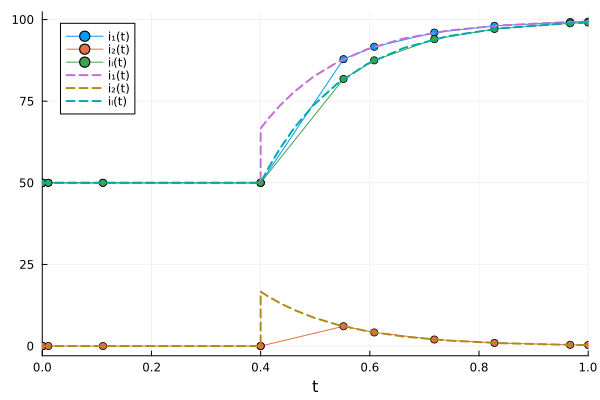

In [26]:
prob = ODEProblem(sys, [], [0, 1])
sol = solve(prob, tstops=[0.4 + eps()])
plot!(sol, idxs=[i₁, i₂, iₗ], denseplot=false, ls=:dash, lw=2)

### 4.4.4 Динамика популяции при регулировании численности хищников

Используем уравнения Лотки-Вольтерры для моделирования динамики популяции волков и зайцев 

$$\frac{dx}{dt}=\alpha x -\beta yx$$
$$\frac{dy}{dt}=-\gamma y +\delta xy $$

где $x$, $y$ - численность популяции зайцев и волков, $\alpha$, $\delta$ - их постоянные коэффициенты рождаемости, $\beta$, $\gamma$ - их постоянные коэффициенты смертности 

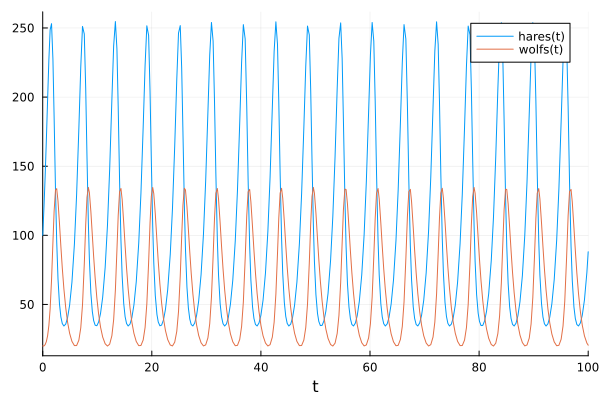

In [27]:
@variables t
@variables wolfs(t) = 20
@variables hares(t) = 100

@parameters α = 1.2 γ = 1.1 β = 0.02 δ = 0.01

eqs = [
    D(hares) ~ ( α - β*wolfs) * hares
    D(wolfs) ~ (-γ + δ*hares) * wolfs
]

@named Population = ODESystem(eqs, t)

prob = ODEProblem(Population, [], [0, 100])
sol = solve(prob, reltol=1e-6)
plot(sol, denseplot=false)

Добавим в модель условие, что когда численность волков превышает 100, то половина истребляется. Причем такое регулирование численности начинает работать с момента t=40

In [28]:
# Самостоятельно

## 4.5 Неожиданные решения (объяснить почему)

### 4.5.1 Несколько одновременных ContinuesCallback

Вернемся к примеру 4.4.2 с мячом и разобъем описание столкновения со ступенями на 2 события. Какой будет результат, если разбить на 3 события?

  3.587642 seconds (4.74 M allocations: 254.803 MiB, 99.39% compilation time)


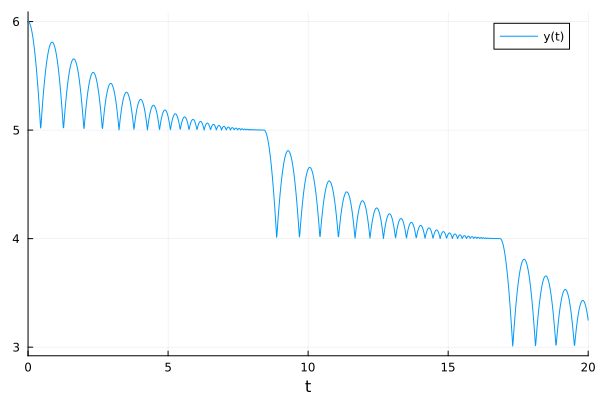

In [29]:
@variables t 
@variables x(t) = 0
@variables y(t) = 6
@variables vx(t) = 1 
@variables vy(t) = 0
@variables h(t) = 5

D = Differential(t)

bump1 = [y ~ h] => [vy ~ -0.9vy; vx ~ 0.9vx]
bump2 = [y ~ h] => [h ~ max(0, h-1)]


eqs = [
    D(x) ~ vx
    D(y) ~ vy
    D(vy) ~ -9.8
    D(vx) ~ 0
    D(h) ~ 0
]
@named Ball = ODESystem(eqs, t; continuous_events = [bump1, bump2])

prob = ODEProblem(Ball, [], [0.0, 20.0])
@time sol = solve(prob)
plot(sol, idxs=y)

In [30]:
ModelingToolkit.continuous_events(Ball)

2-element Vector{ModelingToolkit.SymbolicContinuousCallback}:
 ModelingToolkit.SymbolicContinuousCallback(Equation[y(t) ~ h(t)], Equation[vy(t) ~ -0.9vy(t), vx(t) ~ 0.9vx(t)])
 ModelingToolkit.SymbolicContinuousCallback(Equation[y(t) ~ h(t)], Equation[h(t) ~ max(0, h(t) - 1)])

### 4.5.2 ODAEProblem c callback 

Используем в примере 4.4.3 с электрической цепью конструктор ODAEProblem. Что не так с моделью и как ее исправить?

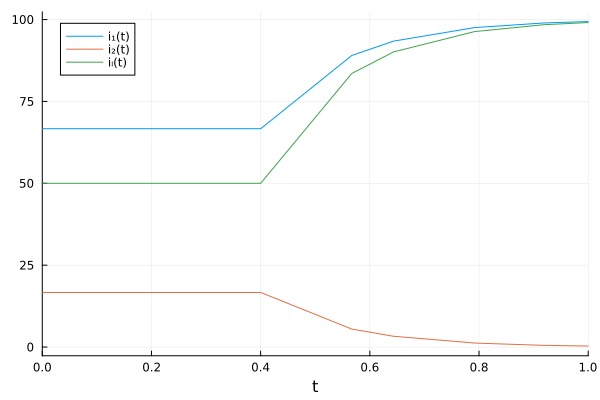

In [31]:
@variables t 
@variables i₁(t) = 50
@variables i₂(t) = 0
@variables iₗ(t) = 50

@parameters E = 10.0 
@parameters r₁ = 0.2 
@parameters r₂ = 0.2 
@parameters L = 0.01 

discrete_events = [[0.4] => [r₁ ~ r₁/2]]
    
der = Differential(t)
eqs = [
    0 ~ i₂ - i₁ + iₗ
    E ~ r₁ * i₁ + r₂ * i₂
    der(iₗ) ~ r₂ * i₂ / L
    ]

@named Circuit = ODESystem(eqs, t, discrete_events = discrete_events)

sys = structural_simplify(Circuit)

prob = ODAEProblem(sys, [], [0, 1])
sol = solve(prob)
plot(sol, idxs=[i₁, i₂, iₗ], denseplot=false)